# Week 6 Lab

In [9]:
%pylab inline

from sympy import *
init_printing(use_unicode = True, fontsize = 16)

pi2 = pi * 2

Populating the interactive namespace from numpy and matplotlib


C:\Softwares\Python\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['floor', 'sin', 'plotting', 'gcd', 'reshape', 'log', 'array', 'cos', 'var', 'sign', 'plot', 'vectorize', 'lcm', 'tan', 'conjugate', 'interactive', 'Polygon', 'mod', 'ones', 'seterr', 'exp', 'fft', 'poly', 'pi', 'f', 'multinomial', 'test', 'power', 'roots', 'sinh', 'source', 'binomial', 'product', 'partition', 'cbrt', 'sinc', 'transpose', 'beta', 'invert', 'sqrt', 'eye', 'diff', 'diag', 'ifft', 'solve', 'nan', 'gamma', 'Circle', 'trunc', 'prod', 'cosh', 'trace', 'det', 'deprecated', 'tanh', 'zeros', 'Line2D', 'flatten', 'add', 'erf', 'take', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
import os
import sys 

if os.name == 'nt':
    path = 'C:\\Users\\Wei\\Dropbox\\Coding\\notebooks\\專案\\待處理\\Waves\\bitbucket\\github\\codes'
else:
    path = '/home/wei/Dropbox/Coding/notebooks/專案/待處理/Waves/bitbucket/github/codes'
    
sys.path.append(path)

from waves.sound import *
from waves.tools.dsp import *

## 藉由 sinc 方法產生的 impulse response 來產生 Low pass filter，會有精度的問題

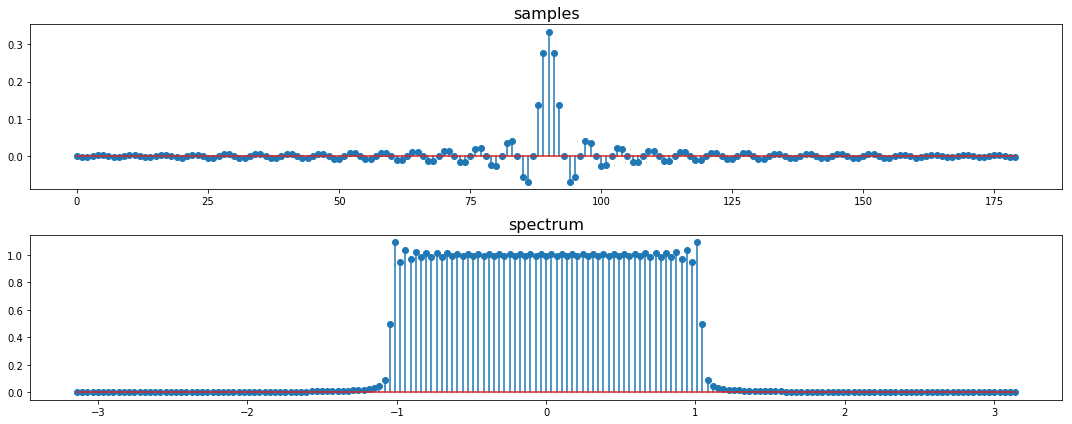

In [11]:
h = Filter.low_pass_filter_impulse_response(cutoff_ratio = 1/3)
H = Fourier.dtft(h)

## 先產生 ideal low pass filter 的 spectrum，再產生對應的 impulse response

C:\Softwares\Python\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


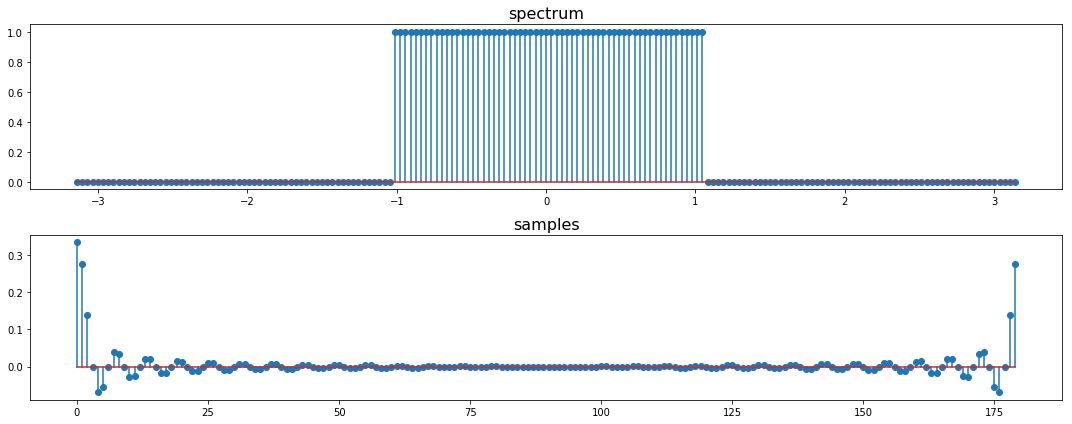

In [12]:
w = DSP.get_freq_bins()
H = np.zeros_like(w)
H[(-np.pi/3 <= w) & (w <= np.pi/3)] = 1
h = Fourier.idtft(H)

# 使用 Window method 來設計實用的 filter

### 使用 Sinc function 時， M = 1000 所產生的 impulse response 已經可以很完善的當作 ideal low pass filter

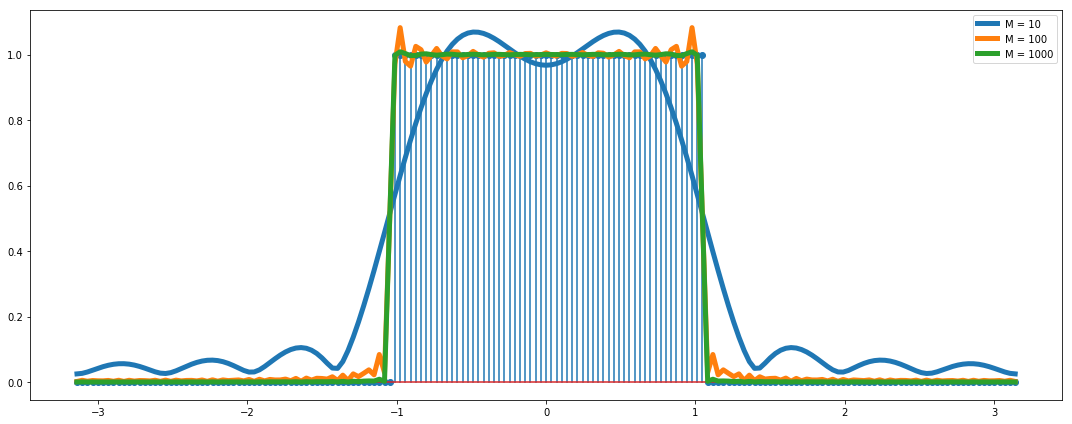

In [13]:
from scipy.signal import hilbert


w = DSP.get_freq_bins()
plt.figure(figsize = TWO_ROWS_FIGSIZE)

def plot_lp_spectrum(w):
    Fourier.plot = True
    plt.stem(w, H)
    
def plot_envelopes(w):
    Hs = []
    
    Fourier.plot = False
    for M in 10**np.arange(1, 4): 
        h = Filter.low_pass_filter_impulse_response(cutoff_ratio = 1/3, n_samples = M)
        Hs.append((M, Fourier.dtft(h)))

    Fourier.plot = True
    for H_m in Hs:
        plt.plot(w, hilbert(abs(H_m[1])), linewidth = 5, label = 'M = {}'.format(H_m[0]))    

plot_lp_spectrum(w)
plot_envelopes(w)
plt.legend()
plt.tight_layout()
plt.show()

### 使用 window_size = 90 的 window 直接擷取 ideal low pass filter 的 impulse response，才能完美複製效果
但是 90 還是太大了一些

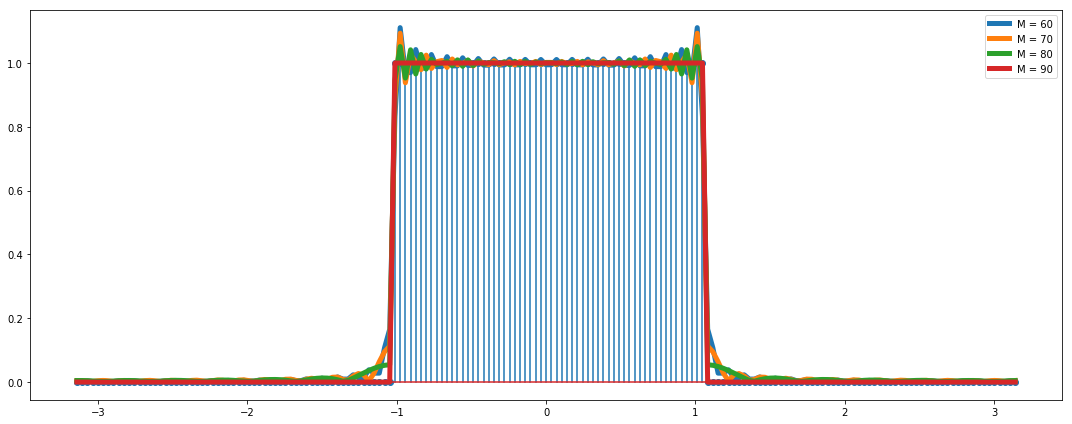

In [14]:
w = DSP.get_freq_bins()
plt.figure(figsize = TWO_ROWS_FIGSIZE)

    
def chunk_ir(h, M = 9):
    N = len(h)
    h1_l = h[N//2+1:][-M:]
    h1_r = h[:N//2][:M]
    h1 = np.concatenate((h1_l, h1_r)) 
    return h1
    
def plot_envelopes(w):
    Hs = []
    
    Fourier.plot = False 
    for M in 10*np.arange(6, 10):   
        h1 = chunk_ir(h, M)        
        Hs.append((M, Fourier.dtft(h1)))

    Fourier.plot = True
    for H_m in Hs:
        plt.plot(w,  hilbert(abs(H_m[1])), linewidth = 5, label = 'M = {}'.format(H_m[0]))    

plot_lp_spectrum(w)
plot_envelopes(w)
plt.legend()
plt.tight_layout()
plt.show()

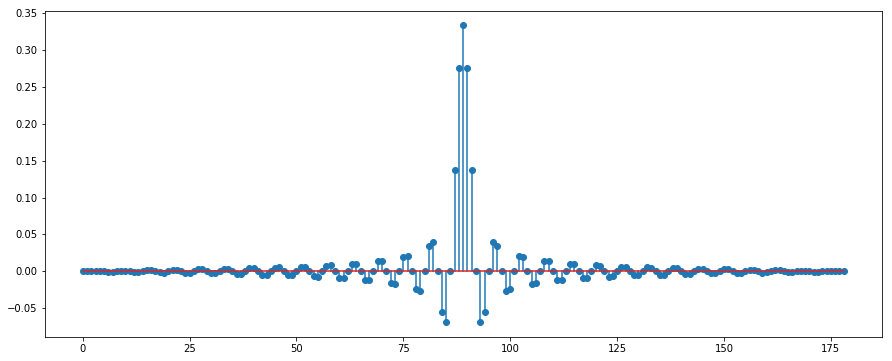

In [15]:
# M = 90 is good enough.

h1 = chunk_ir(h, 90)

plt.figure(figsize = TWO_ROWS_FIGSIZE)
plt.stem(h1);

### 各種 window 的效果

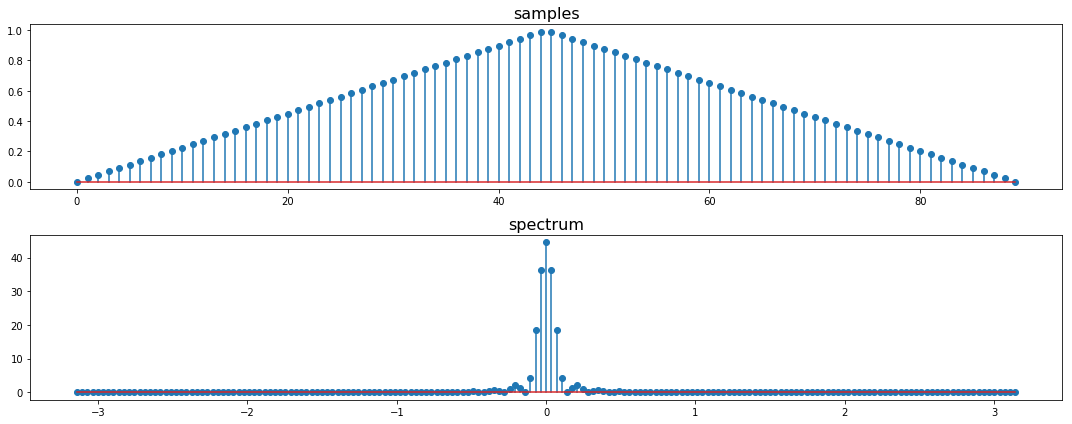

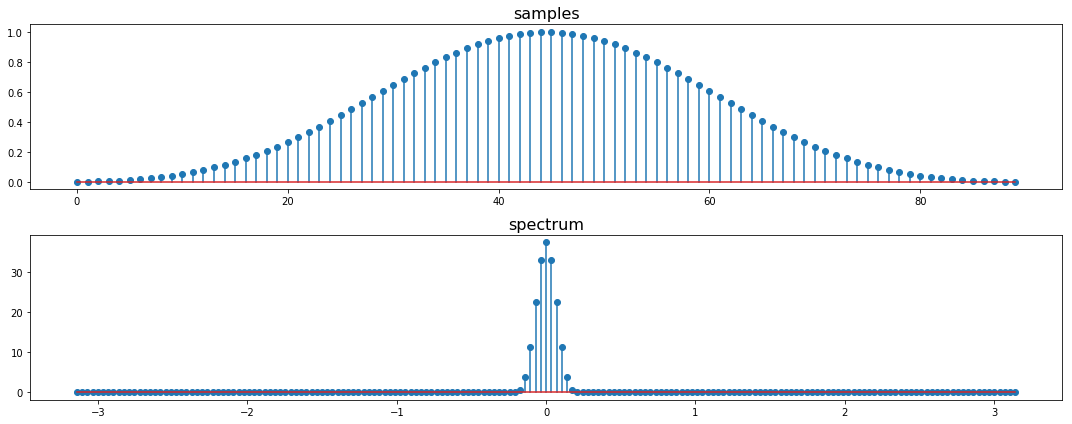

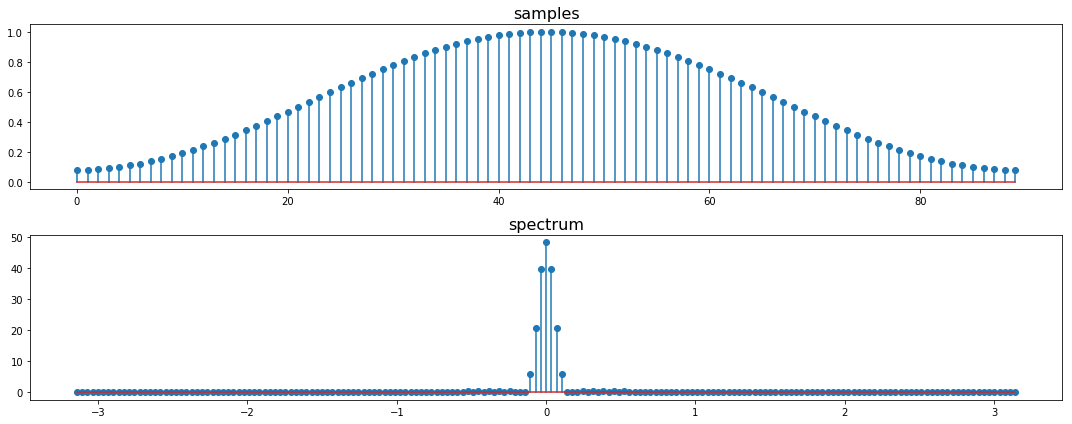

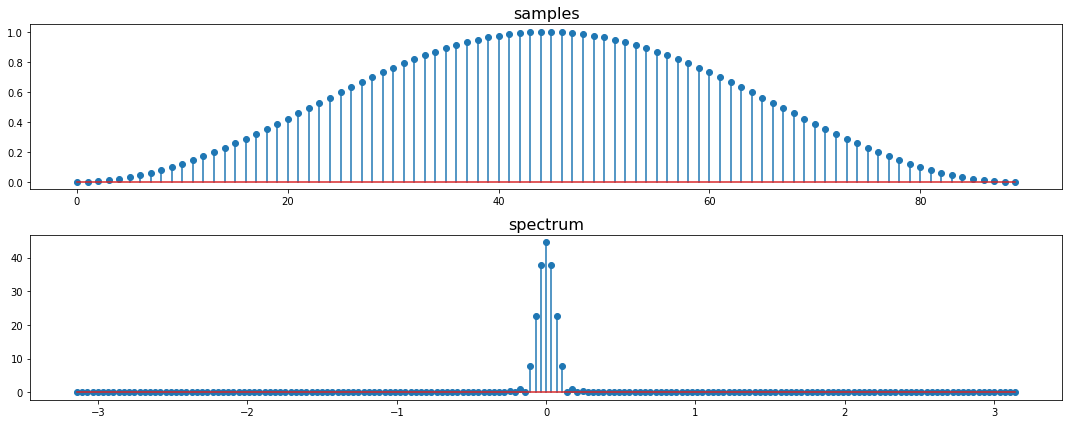

In [16]:
def plot_window_function(M = 90):
    for fn in ['bartlett', 'blackman', 'hamming', 'hanning']:#, 'kaiser']:
        f = getattr(np, fn)
        _ = Fourier.dtft(f(M))
        
plot_window_function()

### 使用 blackman window 來產生趨近 ideal low-pass filter 的 impulse response

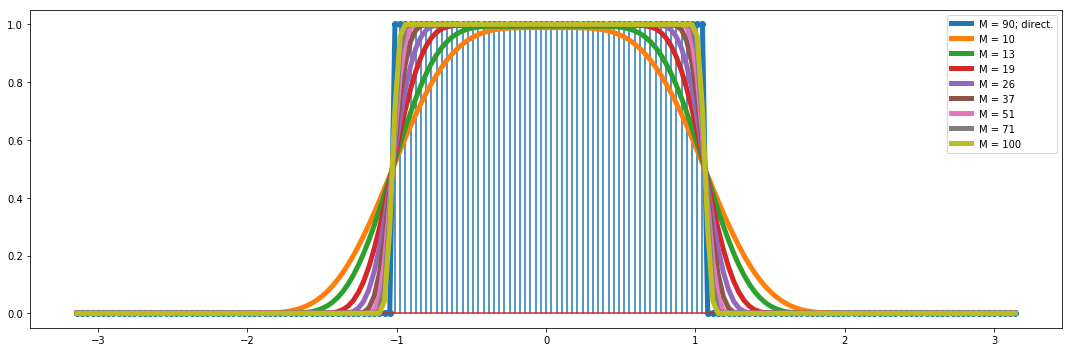

In [17]:
w = DSP.get_freq_bins()
plt.figure(figsize = (15, 5))


# def chunk_ir(h, M):
#     N = len(h)
#     h1_l = h[N//2+1:][-M:]
#     h1_r = h[:N//2][:M]
#     h1 = np.concatenate((h1_l, h1_r)) 
#     return h1

def windowed_fir(h, M, method = 'blackman'):    
    h1 = chunk_ir(h, M)    
    f = getattr(np, method)
    window = f(len(h1))  
    return h1 * window
    
def plot_envelopes(w):
    Hs = []
    
    Fourier.plot = False
    for M in (10**np.linspace(1, 2, 8)).astype(int):   
        h1 = windowed_fir(h, M)
        Hs.append((M, Fourier.dtft(h1)))

    Fourier.plot = True
    for H_m in Hs:
        plt.plot(w,  hilbert(abs(H_m[1])), linewidth = 5, label = 'M = {}'.format(H_m[0]))   
        
Fourier.plot = False
plt.plot(w, hilbert(abs(Fourier.dtft(chunk_ir(h, 90)))), linewidth = 5, label = 'M = {}; direct.'.format(90))

plot_lp_spectrum(w)
plot_envelopes(w)
plt.legend()
plt.tight_layout()
plt.show()

### 可是使用 M = 37 來節省計算資源。但是如果需要很精確，還不如直接由 ideal impulse response 直接取 M = 90 的區塊。

### Flip IDTFT 所產出的  samples

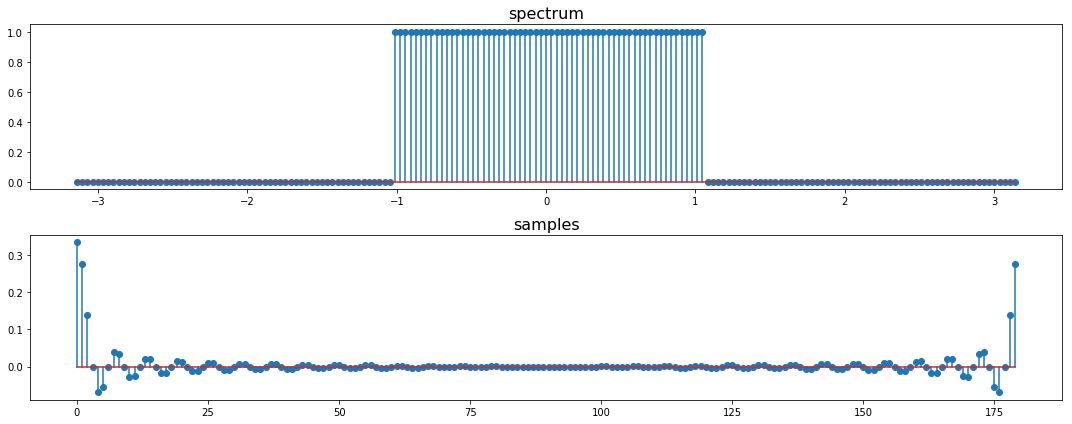

In [18]:
h = Fourier.idtft(H, plt_abs=False)

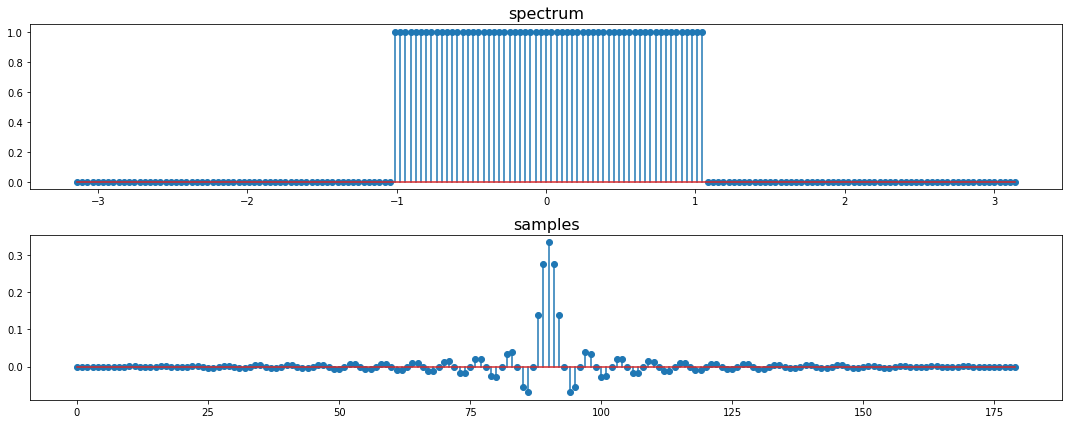

In [19]:
h = Fourier.idtft(H, plt_abs=False, flip_samples=True)

### Summary of Lesson 4.6
In this lesson, we have studied different methods to approximate an ideal filter.

The first method is called **impulse truncation**: we simply truncate the filter impulse response over a finite set of NN points, centered around zero. While, it seems like a good idea in the first place, as this method minimises the mean squared error between the ideal and the approximate filter, this method suffers from an important limitation known as **Gibbs phenomenon**. The maximum error around the transition band cannot be made arbitrarily small, even when we increase the number of points N.

The impulse truncation can be interpreted as the product of the ***ideal filter response*** and a ***rectangular window of N points***. From the **modulation theorem**, the ***DTFT of the product of two signals is equivalent to the convolution of their DTFTs***. Hence, the choice of window influences the quality of the approximation results. The **window method** is just a generalization of the impulse truncation method where we use a different window shape. For example, by using a triangular window, we reduce the Gibbs error at the price of a longer transition.

The third approximation we have studied is called **frequency sampling**: we sample the impulse of the ideal filter in the frequency domain and obtain the impulse response of the filter by computing the IDFT of these samples. Again, this method does not allow to control the maximum error in the passband and/or the stopband.

# Z transform 
## 4.8.a Intuitive IIR designs

## Z transform of Leaky Integrator

$
\begin{align}
y[n] &= (1-\lambda)x[n] + \lambda y[n-1] \\
Z\{y[n]\} &= Z\{(1-\lambda)x[n] + \lambda y[n-1]\} \\
Y(z) &= {(1-\lambda)X(z) + \lambda z^{-1} Y(z)} \\ 
Y(z) - \lambda z^{-1} Y(z) &= (1-\lambda)X(z) \\
(1-\lambda z^{-1}) Y(z) &= (1-\lambda)X(z) \\
H(z) = \frac{Y(z)}{X(z)} &= \frac{1-\lambda}{1-\lambda z^{-1}}
\end{align}
$

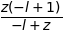

In [20]:
G0, l, w0, w = symbols('G0, l, w0, w', real = True)
H, p, z = symbols('H, p, z')

# z = E**(I*w) 
p = E**(I*w0)

num = (1 - l)
# num = num.collect(z).rewrite(cos).simplify()

denum = (1 - l*z**(-1))
denum = denum.expand().collect(z).rewrite(cos).simplify()

H = num / denum
H

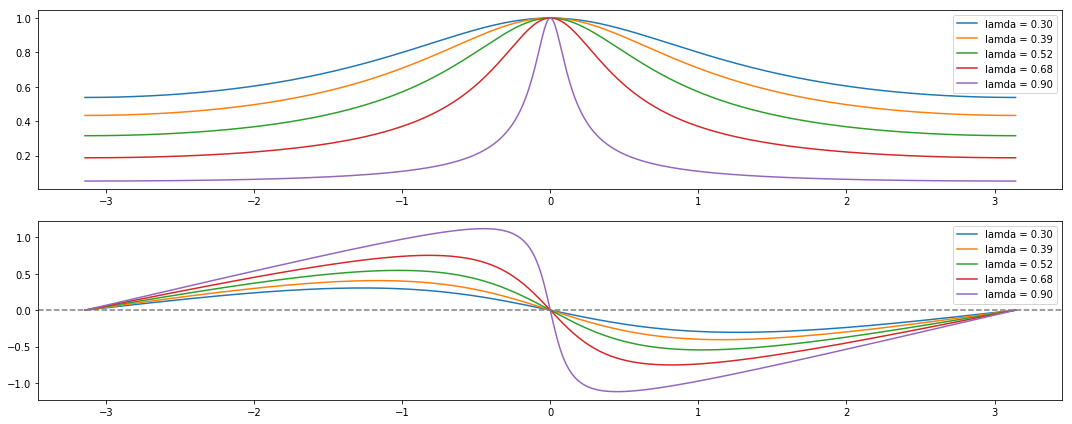

In [21]:
fig, axs = plt.subplots(2, 1, figsize = TWO_ROWS_FIGSIZE)

lamdas = 10**np.linspace(np.log10(0.3), np.log10(0.9), 5)
w = np.linspace(-1, 1, 1000) * np.pi
z = np.exp(1j*w)

def get_H(l = 0.97):
#     H = (1-l) / (1-l*z**(-1))
    H = z*(1-l) / (z-l)  # this also do.
    return H
    
for l in lamdas:     
    H = get_H(l = l)
    axs[0].plot(w, np.abs(H) , label = 'lamda = {:0.2f}'.format(l)) 
    axs[1].plot(w, np.angle(H) , label = 'lamda = {:0.2f}'.format(l))

axs[1].axhline(0, color = 'grey', linestyle = '--')    
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

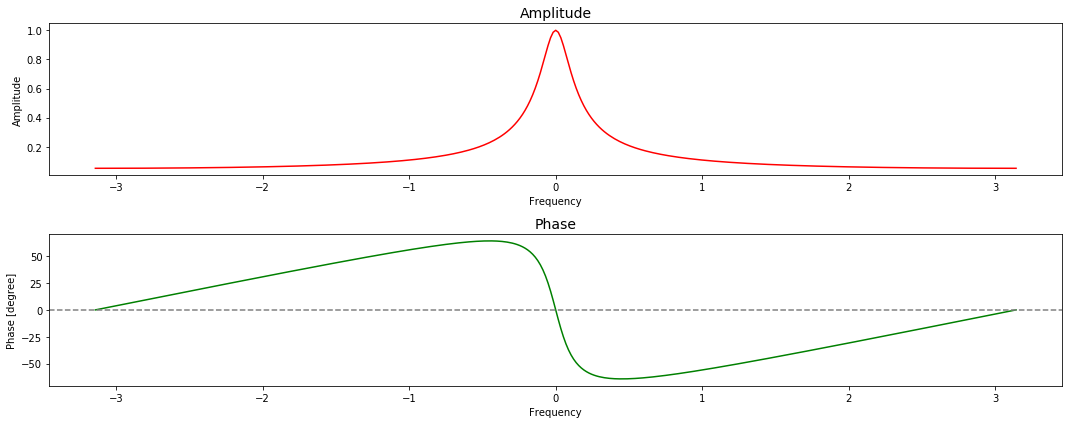

In [22]:
l = 0.9
f, h = Filter.get_H_from_polynomials([[1-l]],[[1, -l]], 360, plot = True)

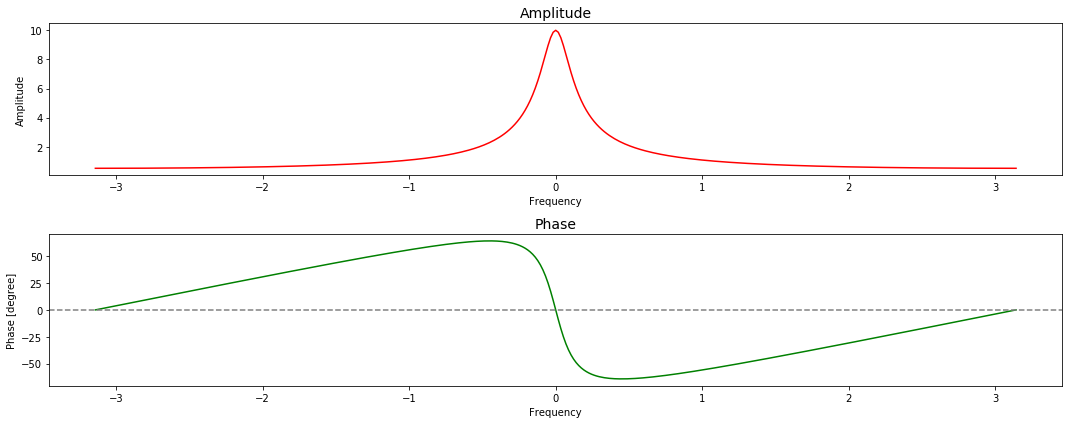

In [69]:
l = 0.9
f, h = Filter.get_H_from_zeros_poles([0],[l], 360, plot = True)

## Z transform of resonator (band-pass filter)
$
\begin{align}
y[n] &= G0 x[n] + a1 y[n-1] + a2 y[n-2] \\
H(z) = \frac{Y(z)}{X(z)} &= \frac{G0}{(1-p z^{-1})(1-\bar{p} z^{-1})} \hspace{2cm} p = \lambda e^{j\omega_0} \\
H(z) &= \frac{G0}{1 - (p +\bar{p})z^{-1} + p\bar{p} z^{-2}} \\
H(z) &= \frac{G0}{1 - 2\lambda\cos(\omega_0)z^{-1} + |\lambda|^2 z^{-2}} \space \Rightarrow \space a1 = -2\lambda\cos(\omega_0) ;\space a2 = |\lambda|^2 \\
\end{align}
$

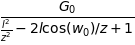

In [24]:
G0, l, w0, w = symbols('G0, l, w0, w', real = True)
H, p, z = symbols('H, p, z')

# z = E**(I*w) 
p = E**(I*w0)

num = G0
# num = num.collect(z).rewrite(cos).simplify()

denum = ((1-l*p*z**(-1))*(1-l*conjugate(p)*z**(-1)))
denum = denum.expand().collect(z).rewrite(cos).simplify()

H = num / denum
H

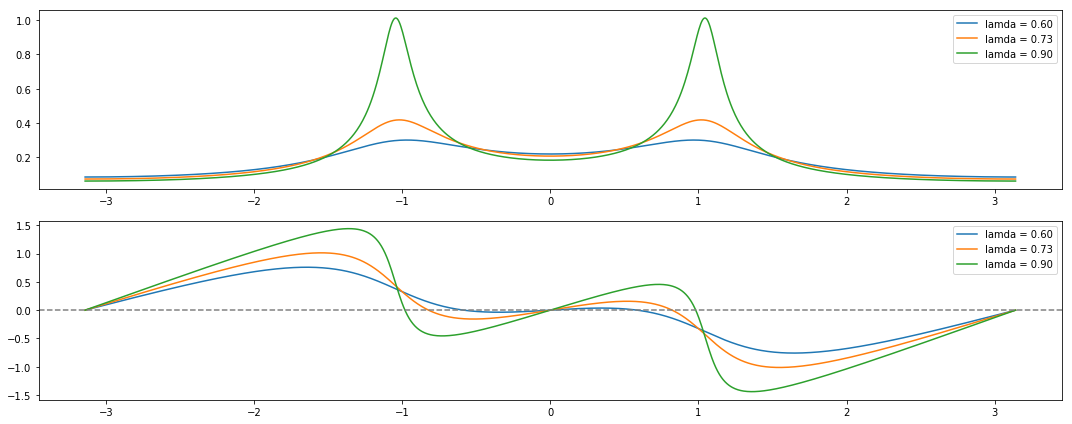

In [73]:
fig, axs = plt.subplots(2, 1, figsize = TWO_ROWS_FIGSIZE)

lamdas = 10**np.linspace(np.log10(0.6), np.log10(0.9), 3)
w = np.linspace(-1, 1, 1000) * np.pi
z = np.exp(1j*w)

def get_H(l = 0.97, w0 = np.pi/3, G0 = 1/6): 
    p = np.exp(1j*w0)
    H = G0 / ((1-l*p*z**(-1))*(1-l*np.conj(p)*z**(-1)))
    return H

w0 = np.pi/3
for l in lamdas:     
    H = get_H(l = l, w0 = w0)
    axs[0].plot(w, np.abs(H) , label = 'lamda = {:0.2f}'.format(l)) 
    axs[1].plot(w, np.angle(H) , label = 'lamda = {:0.2f}'.format(l))

axs[1].axhline(0, color = 'grey', linestyle = '--')    
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

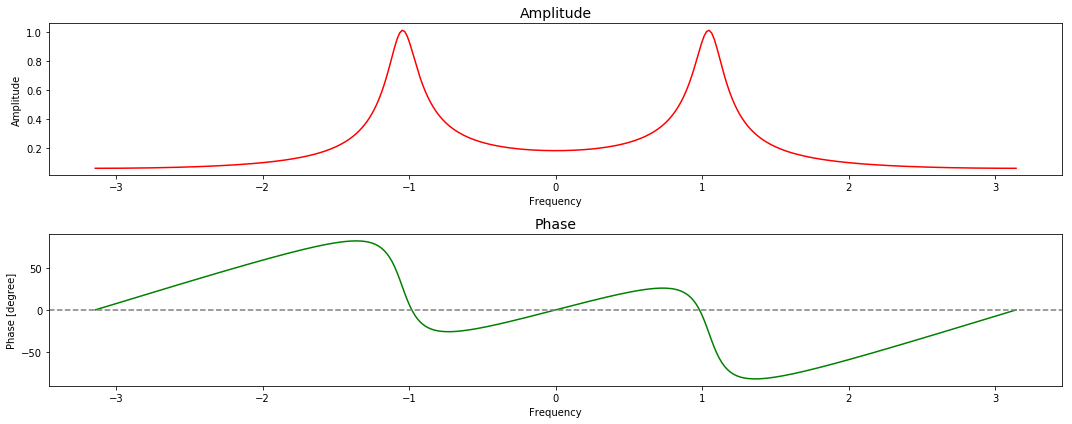

In [74]:
l = 0.9
G0 = 1 / 6
w0 = np.pi/3
p = np.exp(1j * w0)

f, h = Filter.get_H_from_polynomials([[G0]], [[1, -l * p], [1, -l * np.conj(p)]], 360, plot = True)

## Z transform of DC-removal
- DC-balanced signal has zero-sum.  
- DTFT at 0 is 0.  

$
\begin{align}
\lim_{N \to \infty} \sum_{n = -N}^{N} x[n] &= 0 \\
X(0) = \sum_{n = -\infty}^{\infty} x[n]e^{j0n} = \sum_{n = -\infty}^{\infty} x[n] &= 0 \\
\end{align}
$  
  
  
### According to Z-tranform:  
  
$
\begin{align}
\sum_{k = 0}^{N-1} a_k y[n-k] &= \sum_{k = 0}^{M-1} b_k x[n-k] \\
Y(z)\sum_{k=0}^{N-1}a_k z^{-k} &= X(z) \sum_{k=0}^{M-1} b_k z^{-k} \\
H(z) = \frac{Y(z)}{X(z)} &= \frac{\sum_{k=0}^{M-1} b_k z^{-k}}{\sum_{k=0}^{N-1}a_k z^{-k}} \\
H(z) &= \frac{1 - z^{-1}}{1 - \lambda z^{-1}} \Rightarrow y[n] = \lambda y[n-1] + x[n] - x[n-1] \\
\end{align}
$

In [26]:
G0, l, w0, w = symbols('G0, l, w0, w', real = True)
H, p, z = symbols('H, p, z')

# z = E**(I*w) 
p = E**(I*w0)

num = 1-z**-1
num = num.collect(z).rewrite(cos).simplify()

denum = (1-l*z**-1)
denum = denum.expand().collect(z).rewrite(cos).simplify()

H = num / denum
H

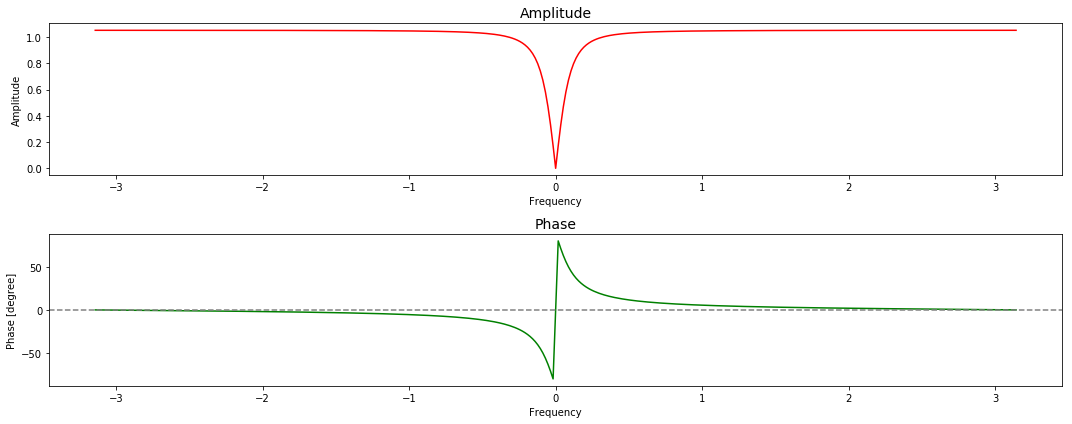

In [76]:
l = 0.9 
f, h = Filter.get_H_from_polynomials([(1, -1)],[(1, -l)], 360, plot = True)

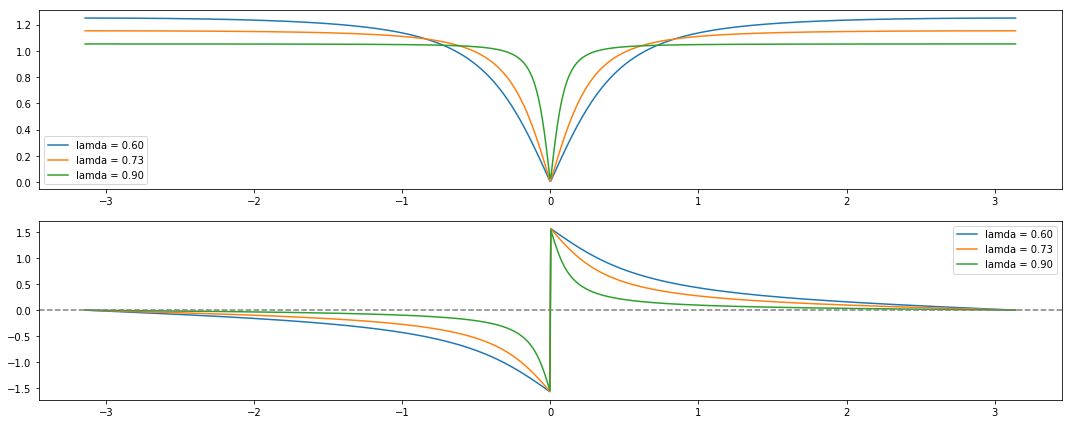

In [27]:
fig, axs = plt.subplots(2, 1, figsize = TWO_ROWS_FIGSIZE)

lamdas = 10**np.linspace(np.log10(0.6), np.log10(0.9), 3)
w = np.linspace(-1, 1, 1000) * np.pi
z = np.exp(1j*w)

def get_H(l):
#     H = (1 - z**-1) / (1 - l * z**-1)
    H = (z-1)/(z-l)
    return H
    
for l in lamdas:     
    H = get_H(l = l)
    axs[0].plot(w, np.abs(H) , label = 'lamda = {:0.2f}'.format(l)) 
    axs[1].plot(w, np.angle(H) , label = 'lamda = {:0.2f}'.format(l))

axs[1].axhline(0, color = 'grey', linestyle = '--')    
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

## Z transform of Hum-removal
- DC-balanced signal has zero-sum.  
- DTFT at 0 is 0.  

$
\begin{align}
X(j\omega_0) = \sum_{n = -\infty}^{\infty} x[n]e^{j\omega_0n} &= 0 \\
\end{align}
$  
  
  
### According to Z-tranform:  
  
$
\begin{align}
p &= e^{j\omega_0} \\
H(z) &= \frac{(1 - p z^{-1})(1 - \bar{p} z^{-1})}{(1 - \lambda p z^{-1})(1 - \lambda \bar{p} z^{-1})} \\
\end{align}
$

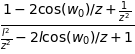

In [28]:
G0, l, w0, w = symbols('G0, l, w0, w', real = True)
H, p, z = symbols('H, p, z')

# z = E**(I*w) 
p = E**(I*w0)

num = ((1-p*z**(-1))*(1-conjugate(p)*z**(-1))) 
num = num.collect(z).rewrite(cos).simplify()

denum = ((1-l*p*z**(-1))*(1-l*conjugate(p)*z**(-1)))
denum = denum.expand().collect(z).rewrite(cos).simplify()

H = num / denum
H

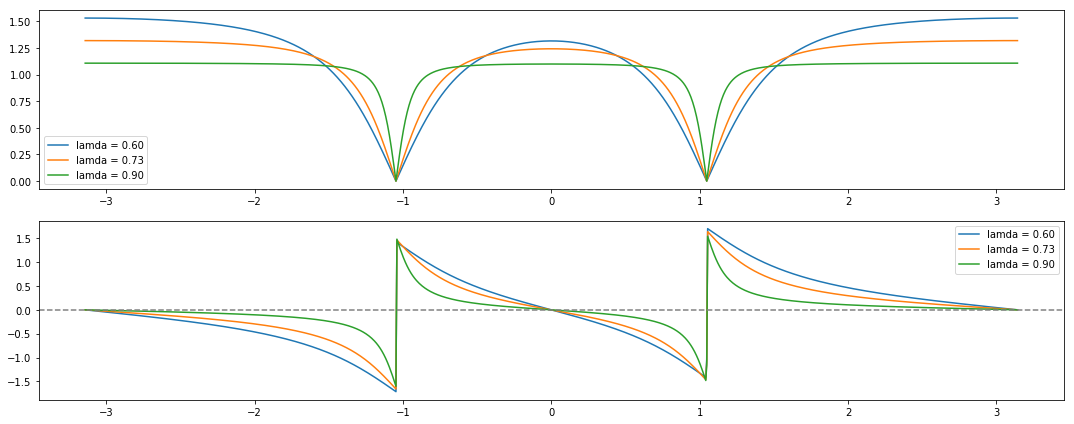

In [29]:
fig, axs = plt.subplots(2, 1, figsize = TWO_ROWS_FIGSIZE)

lamdas = 10**np.linspace(np.log10(0.6), np.log10(0.9), 3)
w = np.linspace(-1, 1, 1000) * np.pi
z = np.exp(1j*w)

def get_H(l = 0.97, w0 = np.pi/3, G0 = 1/6): 
    p = np.exp(1j*w0)
    num = (1-p*z**-1) * (1-np.conj(p)*z**-1) 
    denum = (1-l*p*z**-1) * (1-l*np.conj(p)*z**-1)
    H = num/denum
    return H

w0 = np.pi/3
for l in lamdas:     
    H = get_H(l = l, w0 = w0)
    axs[0].plot(w, np.abs(H) , label = 'lamda = {:0.2f}'.format(l)) 
    axs[1].plot(w, np.angle(H) , label = 'lamda = {:0.2f}'.format(l))

axs[1].axhline(0, color = 'grey', linestyle = '--')    
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

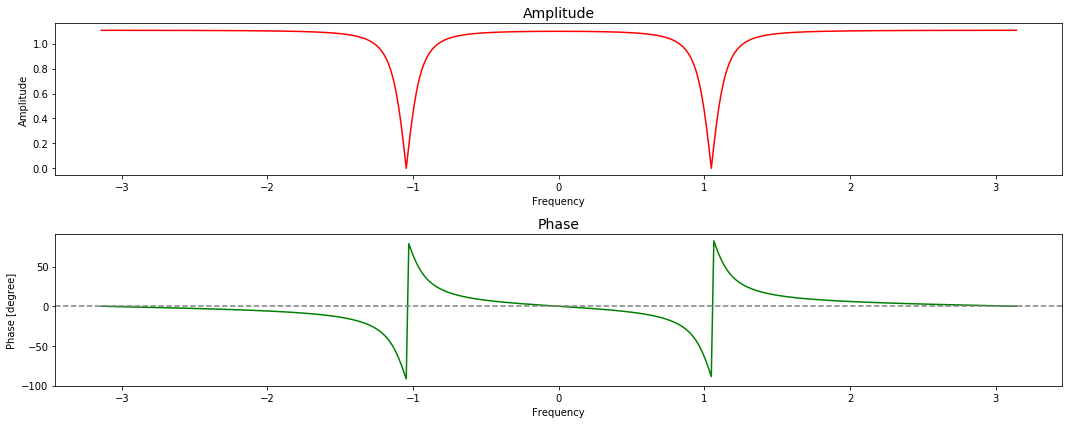

In [77]:
l = 0.9 
w0 = np.pi/3
p = np.exp(1j*w0)
f, h = Filter.get_H_from_polynomials([(1, -p), (1, -np.conj(p))],[(1, -l*p), (1, -l*np.conj(p))], 360, plot = True)

# 4.9.a IIR designs

## Butterworth


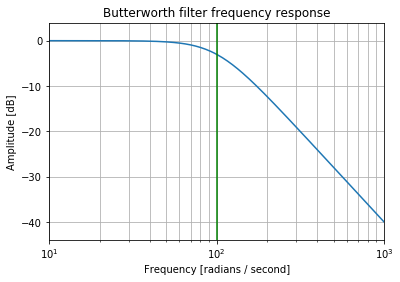

In [30]:
from scipy import signal
import matplotlib.pyplot as plt

b, a = signal.butter(2, 100, 'lowpass', analog=True)  # {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, 
w, h = signal.freqs(b, a)

plt.plot(w, 20 * np.log10(abs(h)))

plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [31]:
# Filter.plot_freq_response(w, h)

## Chebyshev 

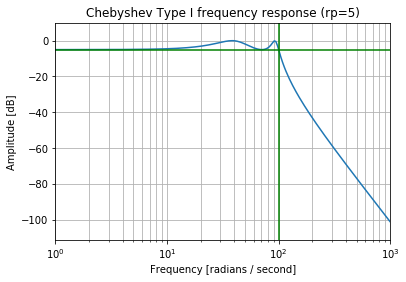

In [32]:
>>> b, a = signal.cheby1(4, 5, 100, 'low', analog=True)
>>> w, h = signal.freqs(b, a)

>>> plt.plot(w, 20 * np.log10(abs(h)))

>>> plt.xscale('log')
>>> plt.title('Chebyshev Type I frequency response (rp=5)')
>>> plt.xlabel('Frequency [radians / second]')
>>> plt.ylabel('Amplitude [dB]')
>>> plt.margins(0, 0.1)
>>> plt.grid(which='both', axis='both')
>>> plt.axvline(100, color='green') # cutoff frequency
>>> plt.axhline(-5, color='green') # rp
>>> plt.show()

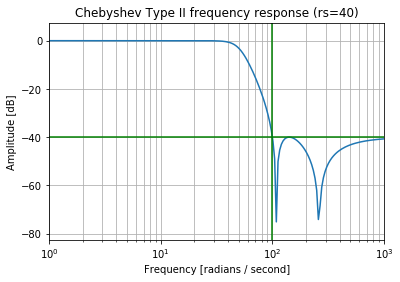

In [33]:
>>> b, a = signal.cheby2(4, 40, 100, 'low', analog=True)
>>> w, h = signal.freqs(b, a)

>>> plt.plot(w, 20 * np.log10(abs(h)))

>>> plt.xscale('log')
>>> plt.title('Chebyshev Type II frequency response (rs=40)')
>>> plt.xlabel('Frequency [radians / second]')
>>> plt.ylabel('Amplitude [dB]')
>>> plt.margins(0, 0.1)
>>> plt.grid(which='both', axis='both')
>>> plt.axvline(100, color='green') # cutoff frequency
>>> plt.axhline(-40, color='green') # rs
>>> plt.show()

## Elliptic

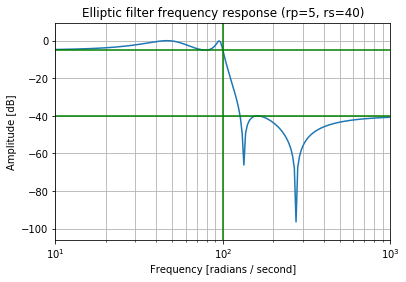

In [34]:
>>> b, a = signal.ellip(4, 5, 40, 100, 'low', analog=True)
>>> w, h = signal.freqs(b, a)

>>> plt.semilogx(w, 20 * np.log10(abs(h)))

>>> plt.title('Elliptic filter frequency response (rp=5, rs=40)')
>>> plt.xlabel('Frequency [radians / second]')
>>> plt.ylabel('Amplitude [dB]')
>>> plt.margins(0, 0.1)
>>> plt.grid(which='both', axis='both')
>>> plt.axvline(100, color='green') # cutoff frequency
>>> plt.axhline(-40, color='green') # rs
>>> plt.axhline(-5, color='green') # rp
>>> plt.show()

## 4.9.c FIR designs

### Minimax

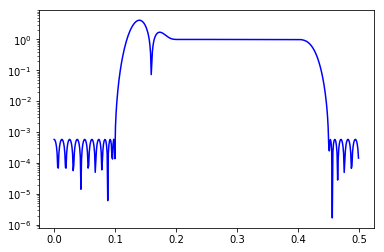

In [35]:
>>> from scipy import signal
>>> bpass = signal.remez(72, [0, 0.1, 0.2, 0.4, 0.45, 0.5], [0, 1, 0])
>>> freq, response = signal.freqz(bpass)
>>> ampl = np.abs(response)
>>>
>>> import matplotlib.pyplot as plt
>>> fig = plt.figure()
>>> ax1 = fig.add_subplot(111)
>>> ax1.semilogy(freq/(2*np.pi), ampl, 'b-')  # freq in Hz
>>> plt.show()

## 4.8.b

## Fractional delay


### 原始的訊號

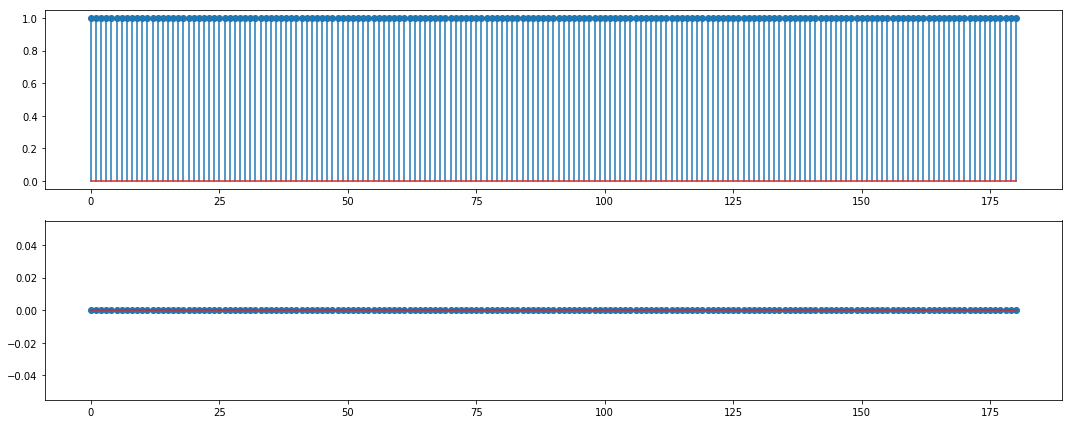

In [36]:
n = np.arange(N_SAMPLES)
w = DSP.get_freq_bins()
X = np.ones_like(w)
DSP.plot_comparison((np.abs(X), np.angle(X)))

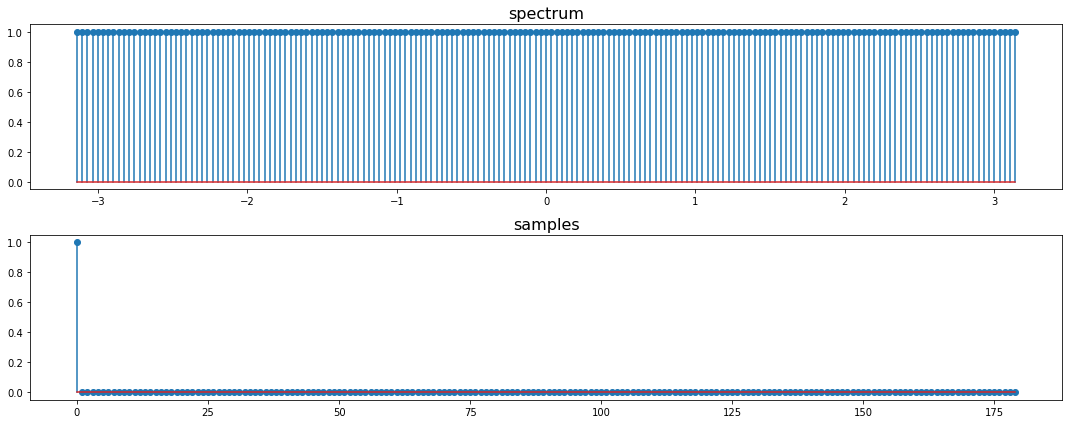

In [37]:
x = Fourier.idtft(X, plt_abs=False)

### 時間上 delay 一個 sample，$\omega$ 中各個頻率會產生 phase shfit，但與頻率成正比，呈現 linear 特性

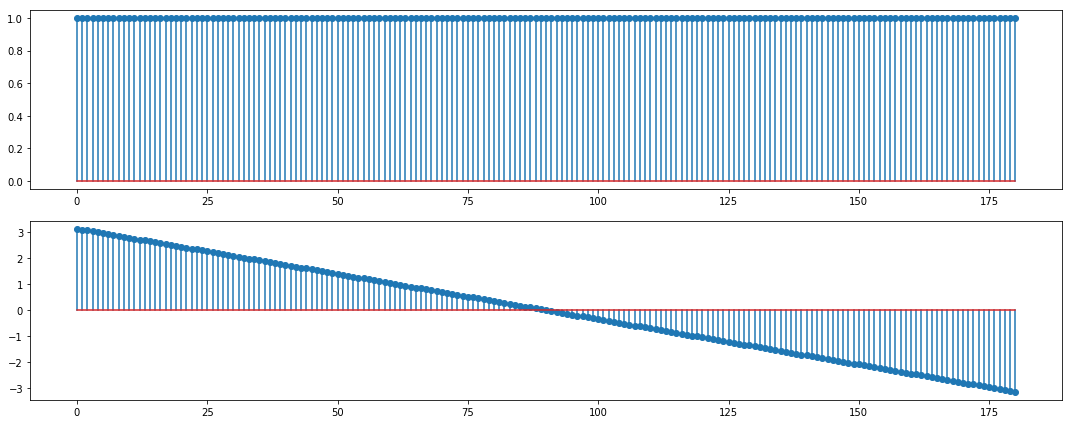

In [38]:
delay = 1
X1 = X * np.exp(1j*w*(-delay))
DSP.plot_comparison((np.abs(X1), np.angle(X1)))

### 訊號頻譜中可以看見個頻率 real 部分的變化

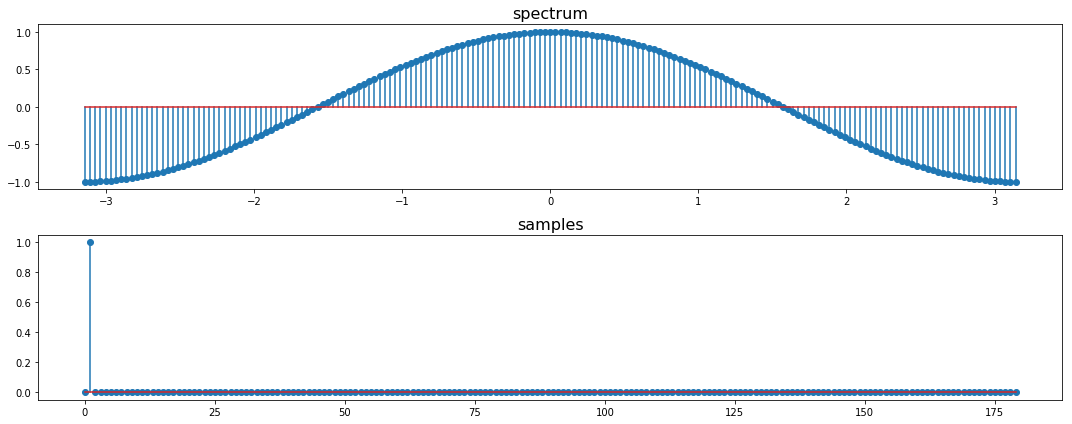

In [39]:
x1 = Fourier.idtft(X1, plt_abs=False)

### Delay 不是整數個 samples 的情況， 𝜔  中各個頻率也會產生 phase shfit，並還是呈現 linear 特性

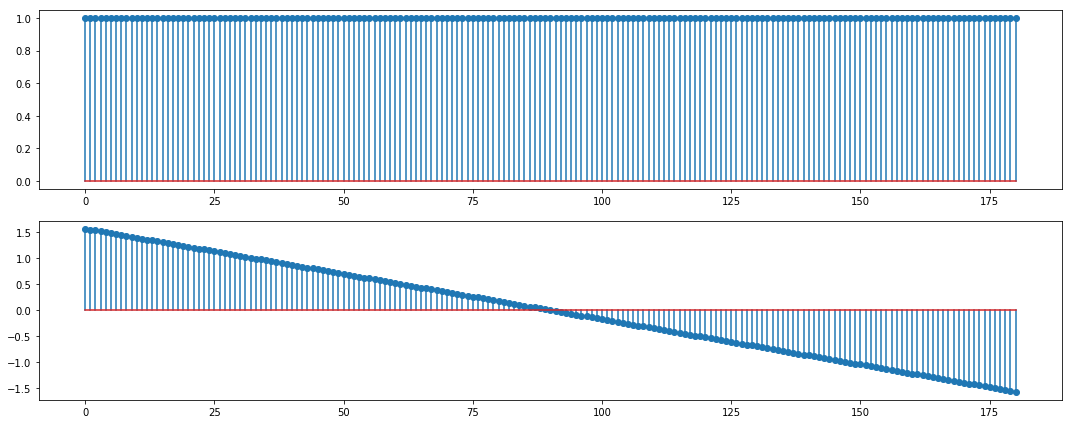

In [40]:
delay = 0.5
X1 = X * np.exp(1j*w*(-delay))
DSP.plot_comparison((np.abs(X1), np.angle(X1)))

### 訊號頻譜中可以看見個頻率 real 部分的變化，但是 samples 不同了

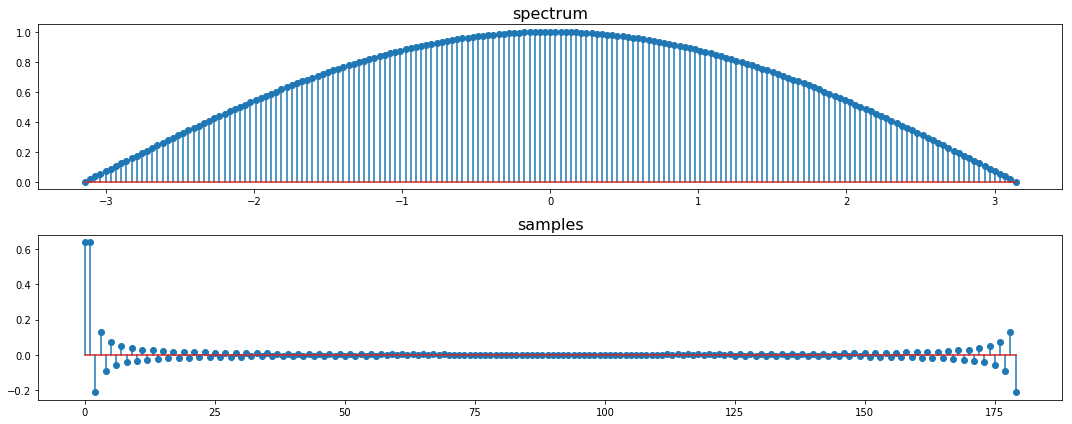

In [41]:
x1 = Fourier.idtft(X1, plt_abs=False, flip_samples=False)

### 一個 sample 的 delay ，其 IDTFT 為:
$
\begin{align}
h[n] = DTFT\{e^{j\omega d}\} &= \frac{1}{2\pi}\int_{-\pi}^{\pi} e^{-j\omega d} e^{j\omega n} d\omega \\
&= \frac{1}{2\pi}\int_{-\pi}^{\pi} e^{j\omega (n-d)} d\omega \\
&= \frac{1}{\pi(n-d)} \frac{e^{j\pi(n-d)} - e^{-j\pi(n-d)}}{2j}  \\
&= \frac{sin(\pi(n-d))}{\pi(n-d)}  \\
&=sinc(n-d) \\
\end{align}
$  

### 當 d 為整數的時候， 因為 n-d為整數，所以 sinc(n-d) = 0，除了 n=d 的時候 sinc(n-d) = sinc(0) = 1


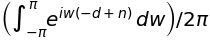

In [42]:
w = symbols('w')
d = symbols('d', real = True)
n = symbols('n', integer = True)
delay = n - d
h = 1/pi2*Integral(E**(-I*w*d) * E**(I*w*n), (w, -pi, pi))
h = h.expand().simplify()
h

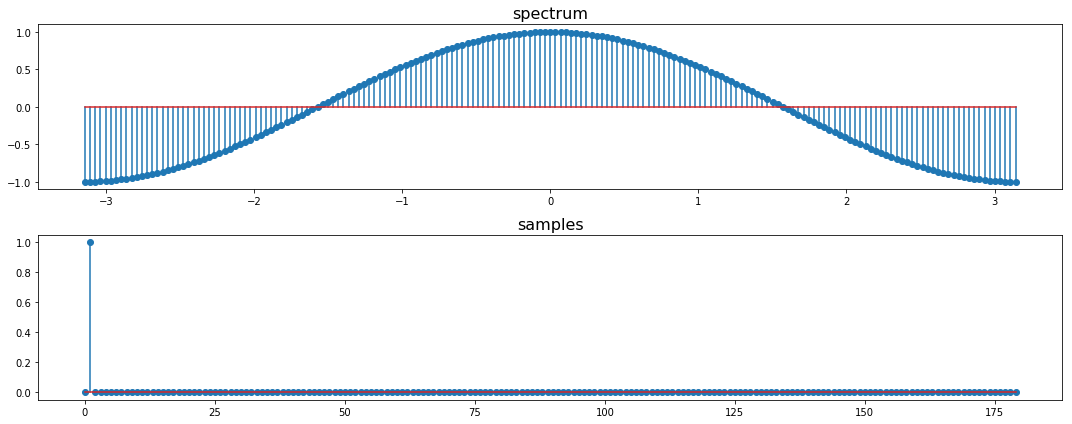

In [43]:
n = np.arange(-N_SAMPLES//2, N_SAMPLES//2)
w = DSP.get_freq_bins()

d = 1
x_delay_1 = Fourier.idtft(np.exp(1j*w*(-d)), plt_abs=False)

###  當 d 為整數的時候， 因為 n-d為整數，所以 sinc(n-d) = 0，除了 n=d 的時候 sinc(n-d) = sinc(0) = 1

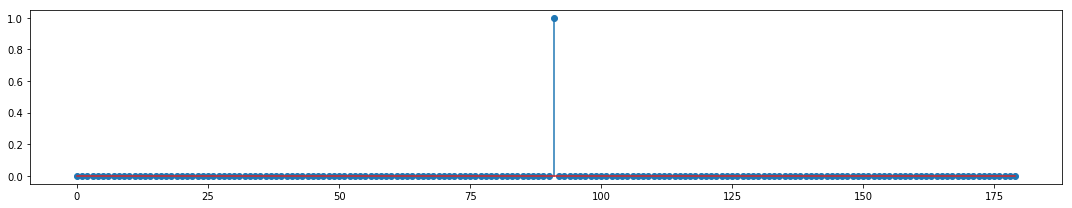

In [44]:
d = 1
DSP.plot_comparison([np.sinc(n-d)])

###  當 d 不為整數的時候， 因為 n-d 不為整數，所以 sinc(n-d) != 0

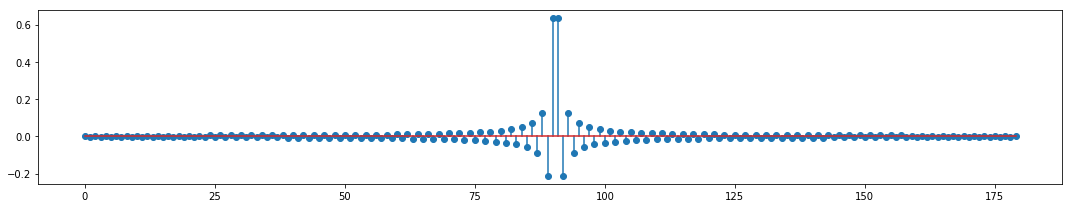

In [45]:
d = 0.5
DSP.plot_comparison([np.sinc(n-d)])

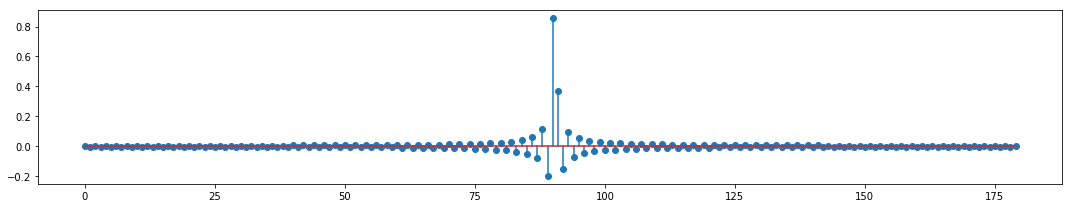

In [46]:
d = 0.3
DSP.plot_comparison([np.sinc(n-d)])

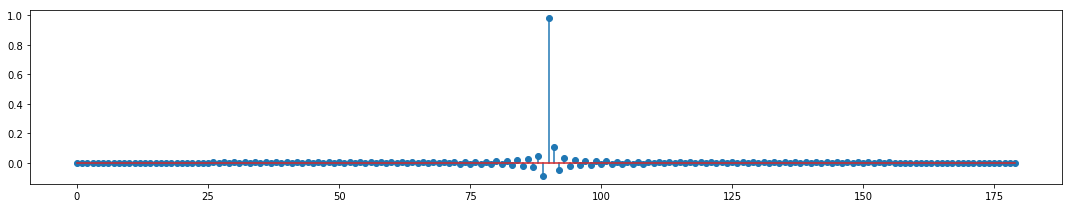

In [47]:
d = 0.1
DSP.plot_comparison([np.sinc(n-d)])

## Hilbert filter
$
\begin{align}
H(e^{j\omega})[\delta(\omega - \omega_0) + \delta(\omega + \omega_0) ]  &= -j[\delta(\omega - \omega_0) - \delta(\omega + \omega_0) ] \\
H(e^{j\omega_0)} &= -j ; \space for 0<=\omega<\pi \\
H(e^{-j\omega_0)} &= j ; \space for -\pi<=\omega<0 \\
\end{align}
$

### Hilbert filter 的 frequency response

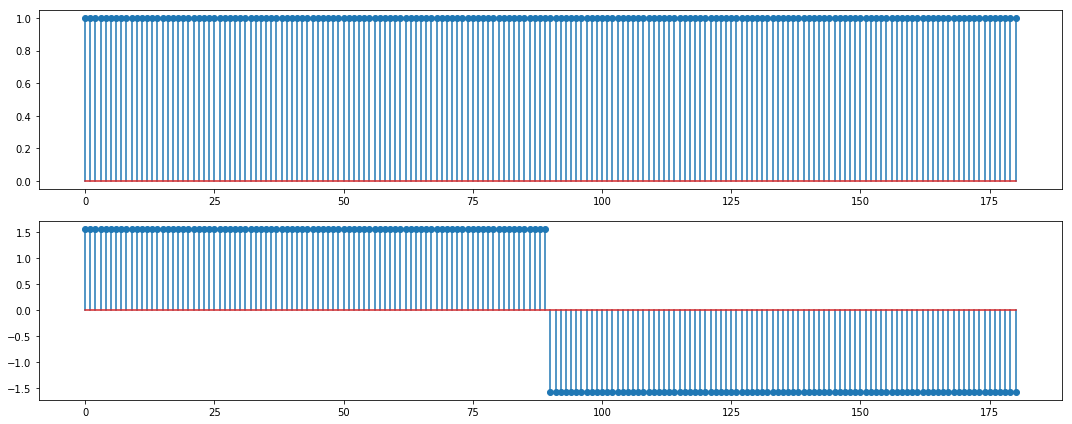

In [48]:
n = np.arange(N_SAMPLES)
w = DSP.get_freq_bins()
H = np.zeros_like(w) * 1j
H[w>=0] = -1j
H[w<0] = 1j
DSP.plot_comparison((np.abs(H), np.angle(H)))

$
\begin{align}
h[n] &= \frac{1}{2\pi} (\int_{-\pi}^{0} je^{j\omega n } d\omega + \int_{0}^{\pi} -je^{j\omega n } d\omega)  \\
&= \frac{1}{2\pi n}[1-e^{-j\pi n} - e^{-j\pi n } + 1]  \\
&=  \begin{cases} 
      \frac{2}{ \pi n} &  n \space odd \\       
      0 &  n \space even \\   
   \end{cases}
\end{align}
$

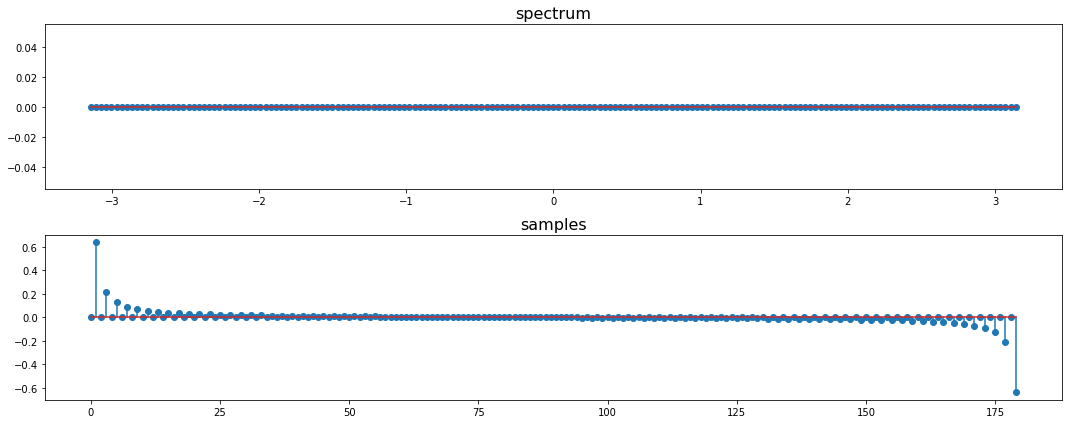

In [49]:
h = Fourier.idtft(H, plt_abs=False, flip_samples=False)

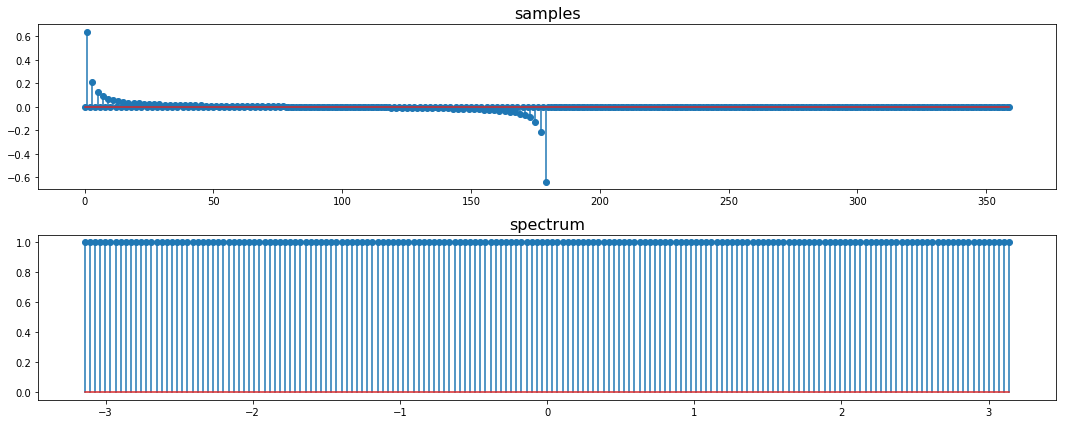

In [50]:
x = DSP.delta(n)
x1 = Convolver.convolve(x, h)
X1 = Fourier.dtft(x1)

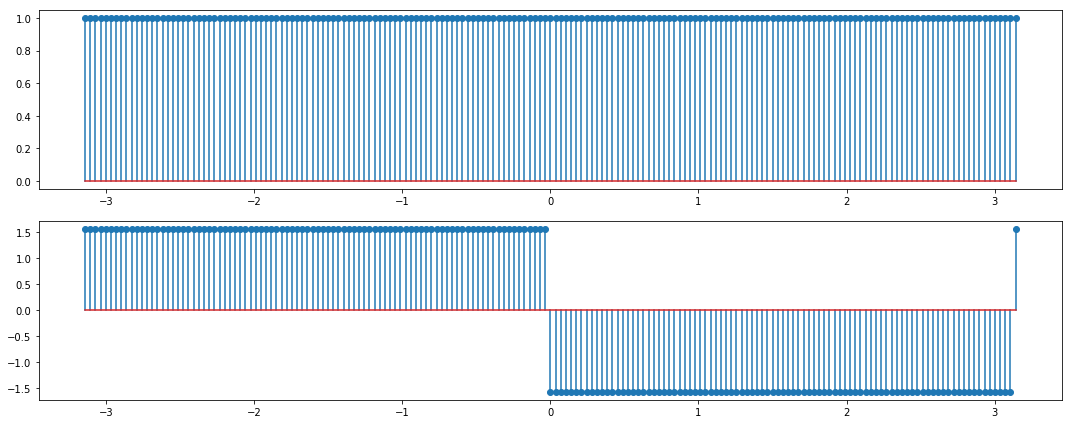

In [51]:
DSP.plot_comparison((np.abs(X1), np.angle(X1)), x_series = (w, w))

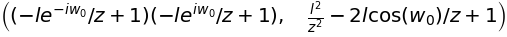

In [52]:
from sympy import symbols, conjugate, E, I
    
l, w0= symbols('l, w0', real = True)
p = E**(I*w0)

product, simplified = Filter.simplify_coefficients_product([(1,-l*p),(1,-l*conjugate(p))])
product, simplified

No handles with labels found to put in legend.
No handles with labels found to put in legend.


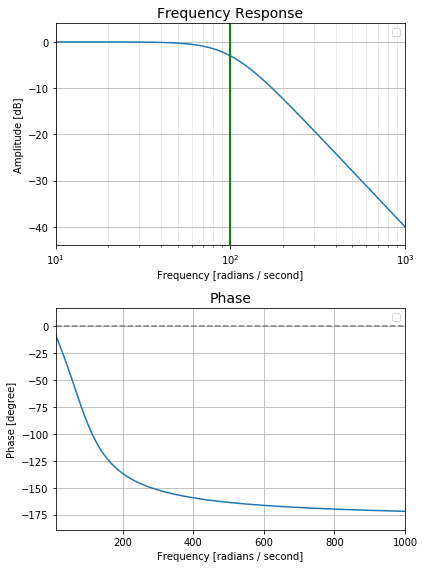

In [53]:
from scipy import signal

b, a = signal.butter(2, 100, 'lowpass', analog=True)  # {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, 
w, h = signal.freqs(b, a)

Filter.plot_freq_phase_response(w, h, wc = [100, ])

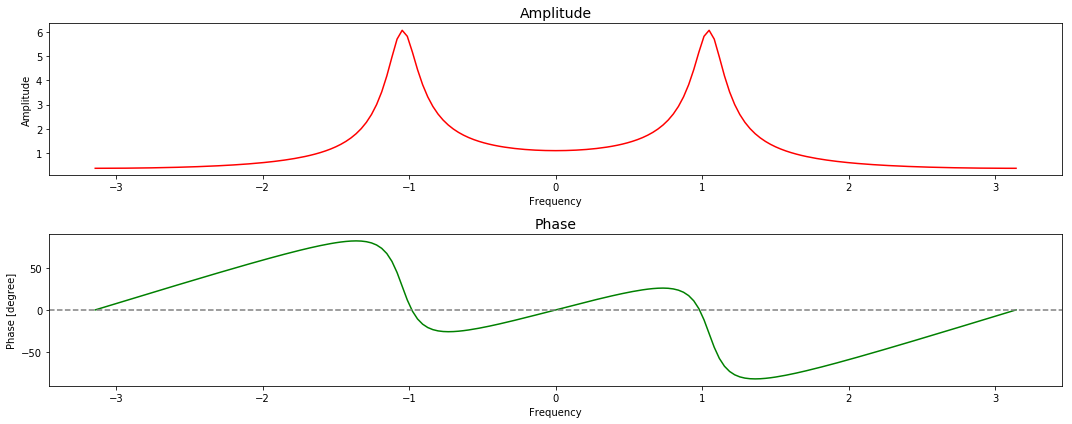

In [54]:
w0 = np.pi/3
p = np.exp(1j*w0)
l = 0.9

b = [1]

poles = [l*p, l*np.conj(p)]
a = Filter.get_polynomials_coeff_from_roots(poles)

w=DSP.get_freq_bins()
freqs, H = Filter.get_H_from_polynomials([b], [a])
Filter.plot_freq_phase_response_pi2(freqs, H)

## MinMax 的 filter 應該具有 linear phase shift

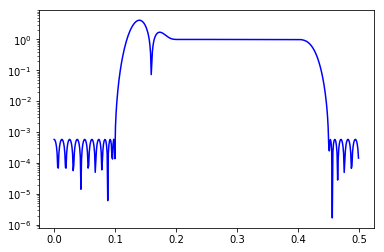

In [55]:
>>> from scipy import signal
>>> bpass = signal.remez(72, [0, 0.1, 0.2, 0.4, 0.45, 0.5], [0, 1, 0])
>>> freq, response = signal.freqz(bpass)#, DSP.get_freq_bins())
>>> ampl = np.abs(response)
>>>
>>> import matplotlib.pyplot as plt
>>> fig = plt.figure()
>>> ax1 = fig.add_subplot(111)
>>> ax1.semilogy(freq/(2*np.pi), ampl, 'b-')  # freq in Hz
>>> plt.show()

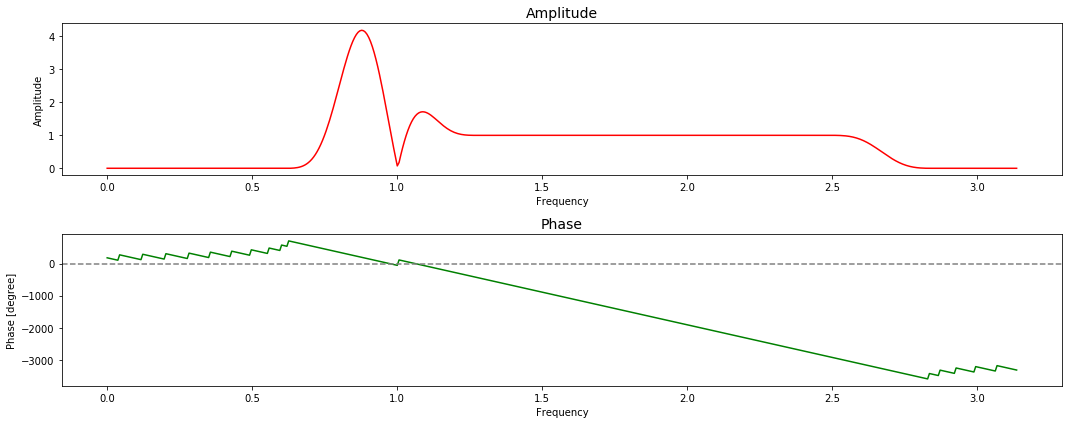

In [56]:
Filter.plot_freq_phase_response_pi2(freq, response)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


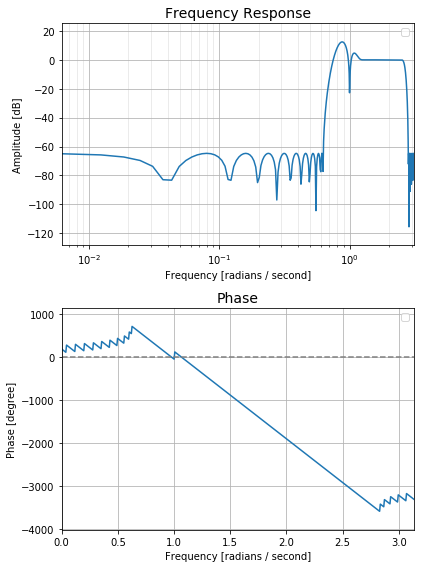

In [57]:
Filter.plot_freq_phase_response(freq, response)

## Notch filter

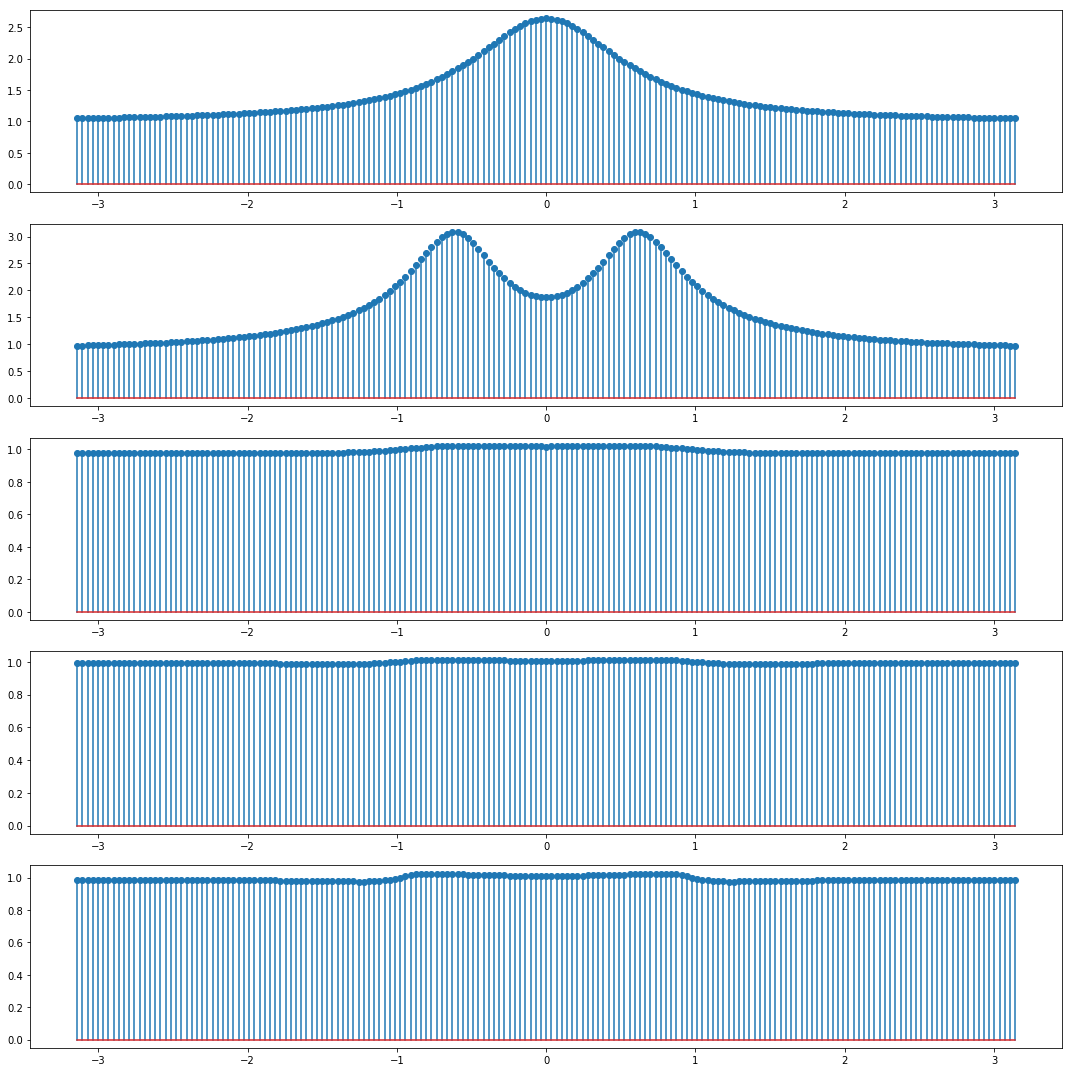

In [58]:
left_filters = [([0.9896542675974899, 0, -0.9896542675974899], [1, -1.2220167447497137, 0.3740876836572318]),
([0.8575094311585659, 0, -0.8575094311585659], [1, -0.6089680324686029, 0.45766341649271447]),
([0.9828956245182227, -0.8923971849328173, 0.9552794404567384], [1, -0.8923971849328173, 0.9381750649749611]),
([0.9932490990628525, -0.5642087106004618, 0.9897175344401132], [1, -0.5642087106004618, 0.9829666335029658]),
([0.9891846844318654, 0.45208706768319745, 0.9613917981531604], [1, 0.45208706768319745, 0.9505764825850258]),]

right_filters = [([0.9896542675974899, 0, -0.9896542675974899], [1, -1.2220167447497137, 0.3740876836572318]),
([0.8575094311585659, 0, -0.8575094311585659], [1, -0.6089680324686029, 0.45766341649271447]),
([0.9828956245182227, -0.8923971849328173, 0.9552794404567384], [1, -0.8923971849328173, 0.9381750649749611]),
([0.9932490990628525, -0.5642087106004618, 0.9897175344401132], [1, -0.5642087106004618, 0.9829666335029658]),
([0.9891846844318654, 0.45208706768319745, 0.9613917981531604], [1, 0.45208706768319745, 0.9505764825850258])]

figs = []
freqs = DSP.get_freq_bins()

for ba in right_filters:
    b, a = ba
    w, h = signal.freqs(b, a, freqs)
    figs.append(abs(h))
    
    
DSP.plot_comparison(figs, [w] * len(figs))

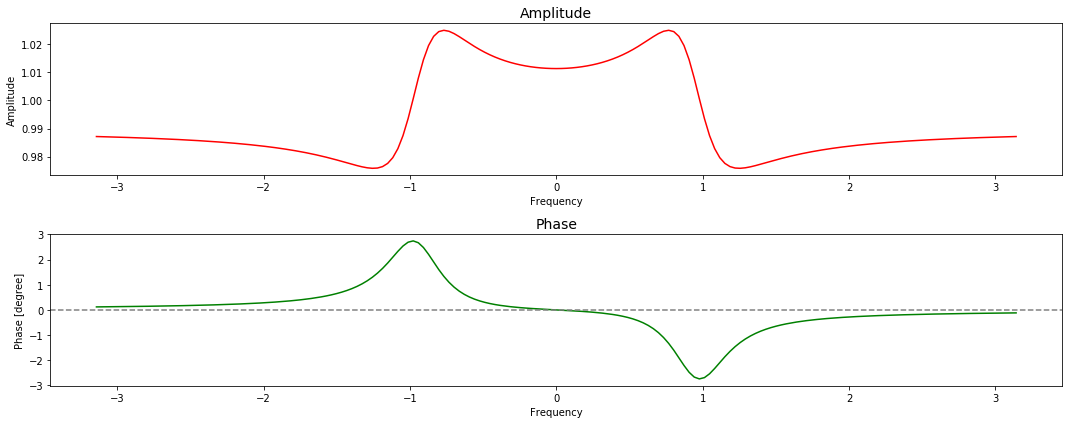

In [59]:
Filter.plot_freq_phase_response_pi2(w, h)

### 將 H(z) 轉成 CCDE

#### Leaky Integrator
$
H(z) = \frac{(1-\lambda)}{1-\lambda z^{-1}} \\
y[n] = (1-\lambda)x[n] + \lambda y[n-1]
$

### Music over Ultrasonic

In [60]:
from waves.sound.tools.synthesizer import *

freq_carrier = 20000
freq_beat  = 0
freq_left  = freq_carrier + freq_beat / 2
freq_right = freq_carrier - freq_beat / 2
sig_l = thinkdsp.SinSignal(freq = freq_left)
sig_r = thinkdsp.SinSignal(freq = freq_right)

ss = StereoSignal(sig_l, sig_r)
ss.play(0.1)

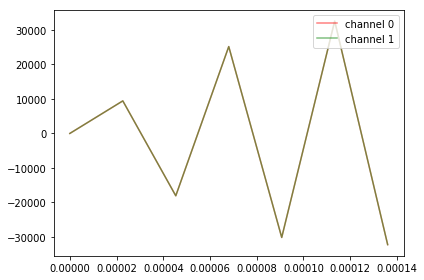

In [61]:
ss.plot()

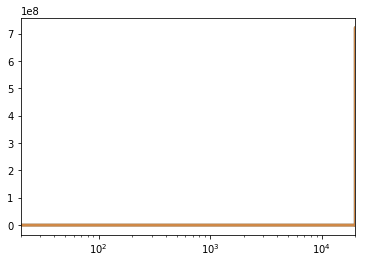

In [62]:
wf = ss.make_waves()
tmb = wf.make_spectrums()
tmb.plot()

In [63]:
tmb.timbers[0].rank_by_amps()

(array([20000., 15900., 11800., ..., 18571., 17178., 11774.]),
 array([7.22498133e+08, 3.90045100e+03, 3.02651042e+03, ...,
        3.75429995e-18, 3.57541808e-18, 3.26823493e-18]))

## example on the net
https://www.youtube.com/watch?v=hri7c5bm-_c  10:00  

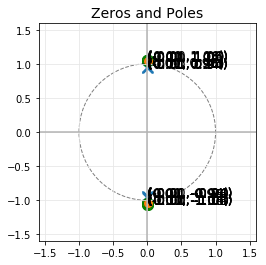

In [64]:
w = DSP.get_freq_bins()
z = np.exp(1j*w)
Hz = ((z**-2 + 0.95**2) / (1 + 0.95**2*z**-2))**8
    
b = np.polynomial.polynomial.polypow([0.95**2, 0, 1], 8) 
a = np.polynomial.polynomial.polypow([1, 0, 0.95**2], 8) 

z, p, k = signal.tf2zpk(b, a)
Filter.plot_zplane(z, p)

#### 作者提供的 H(z)，amplitude 都為 0，不合理

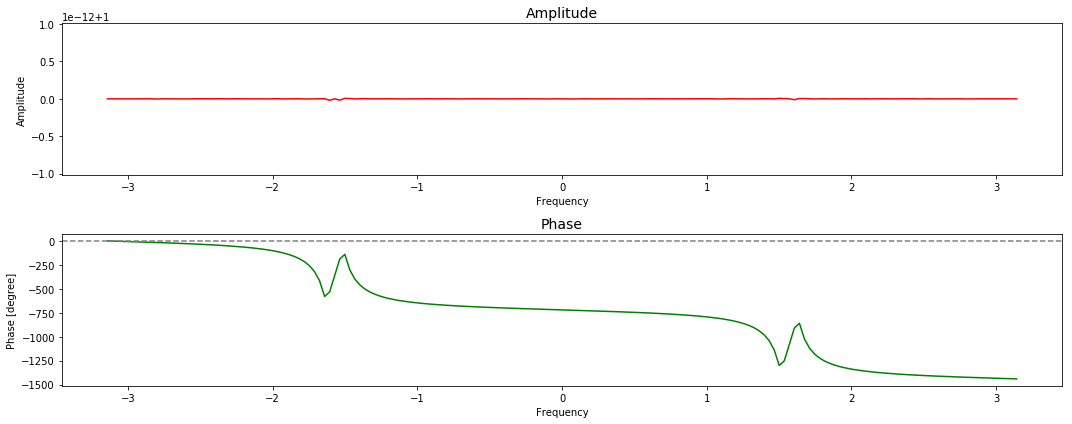

In [65]:
Filter.plot_freq_phase_response_pi2(w, Hz)

#### 先從 zeros, poles 計算出 b, a，再套用 scipy.signal.freqz

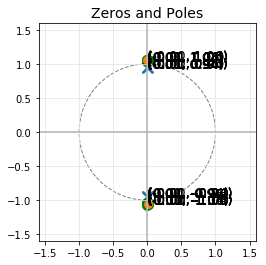

In [66]:
zeros = np.tile([0+1j, 0-1j], 8) / 0.95
poles = np.tile([0+1j, 0-1j], 8) * 0.95

b = Filter.get_polynomials_coeff_from_roots(zeros)
a = Filter.get_polynomials_coeff_from_roots(poles)

z, p, k = signal.tf2zpk(b, a)
Filter.plot_zplane(z, p)

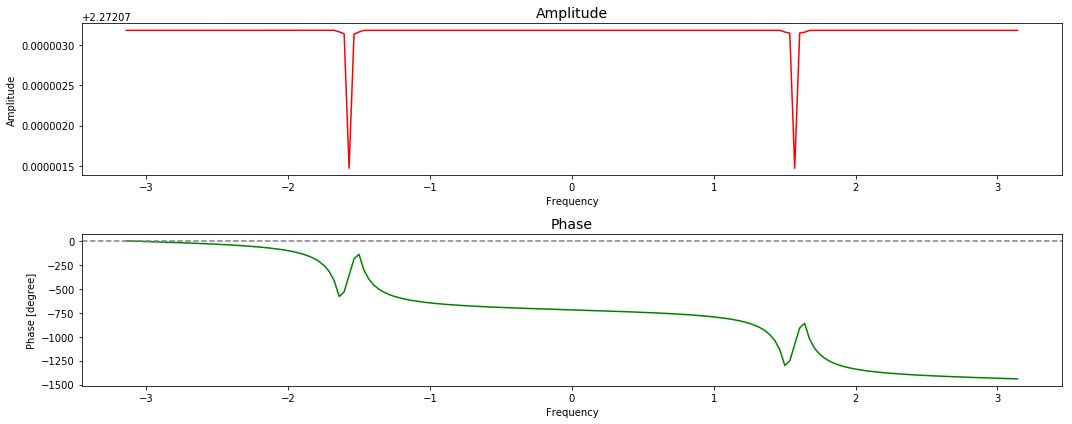

In [67]:
f, h = signal.freqz(b, a, w)
Filter.plot_freq_phase_response_pi2(f, h)

#### 將步驟包在自訂的方法中

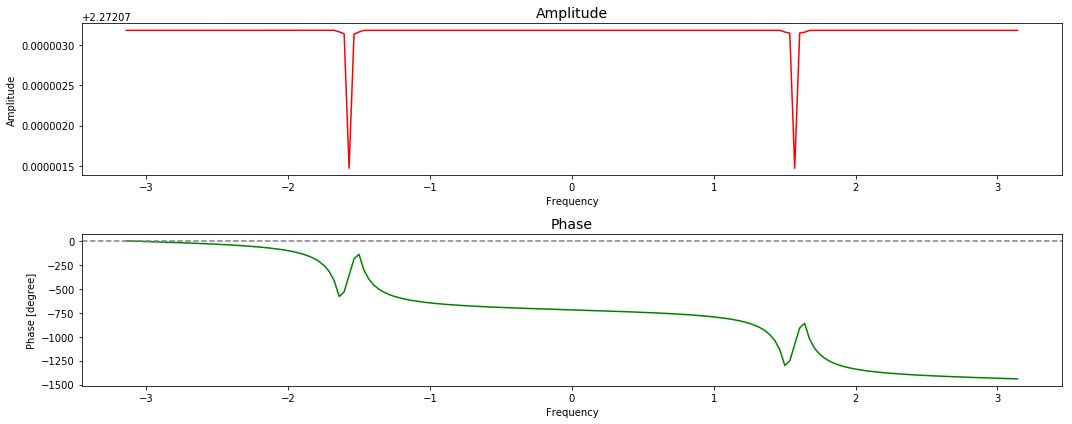

In [68]:
f, h = Filter.get_H_from_zeros_poles(zeros, poles, 180, plot = True) 